In [9]:
import os
import random

import torch
import torch.nn as nn

import pandas as pd
import numpy as np

from monai import data
from monai import transforms

from src.utils.misc import create_dataset

In [2]:
# Define transformation from monai
trans = transforms.Compose(
    [
        # Load the image from file. `LoadImaged` reads the image file specified in the "image" key.
        # `image_only=True` ensures only the image array is loaded, ignoring metadata.
        # `allow_missing_keys=True` avoids errors if the "image" key is not present in the input dictionary.
        transforms.LoadImaged(
            keys=["image"], 
            image_only=True,
            allow_missing_keys=True,
        ),

        # Ensure the loaded image has a channel-first format (C, H, W, D for 3D or C, H, W for 2D images).
        # `allow_missing_keys=True` ensures the transformation can skip if the "image" key is missing.
        transforms.EnsureChannelFirstd(
            keys=["image"],
            allow_missing_keys=True,
        ),

        # Reorient the image to a consistent coordinate system defined by `axcodes="RAS"`.
        # This ensures the orientation matches the Right-Anterior-Superior (RAS) standard.
        transforms.Orientationd(
            keys=["image"], 
            axcodes="RAS",
            allow_missing_keys=True,
        ),

        # Resample the image to have a uniform spacing of (1.0, 1.0, 1.0) mm in each dimension.
        # Uses bilinear interpolation for resampling.
        transforms.Spacingd(
            keys=["image"],
            pixdim=(1.0, 1.0, 1.0),
            mode="bilinear",
            allow_missing_keys=True,
        ),

        # Normalize the intensity values of the image to a specified range [b_min, b_max].
        # The input intensity range is defined by [a_min, a_max].
        # `clip=True` ensures values outside the range are clipped to the nearest boundary.
        transforms.ScaleIntensityRanged(
            keys=["image"],
            a_min=40-150,  # Minimum input intensity
            a_max=40+150,  # Maximum input intensity
            b_min=0.0,     # Minimum output intensity
            b_max=1.0,     # Maximum output intensity
            clip=True,
            allow_missing_keys=True,
        ),

        # Crop out the foreground of the image (non-zero intensity region) to reduce unnecessary background.
        # `source_key="image"` specifies the key in the input dictionary to determine the cropping region.
        # `allow_smaller=False` ensures the resulting image size is not smaller than the requested size.
        transforms.CropForegroundd(
            keys=["image"],
            source_key="image",
            allow_smaller=False,
            allow_missing_keys=True,
        ),

        # Convert the image to a PyTorch tensor for further processing in neural networks.
        transforms.ToTensord(
            keys=["image"],
            allow_missing_keys=True,
        ),
    ]
)

In [3]:
# Sample image path
sample_image = [{'image': '../sample_nifti/ID_c7cc66d672.nii.gz'}]

In [4]:
# Define dataloader and get a scan array
batch_size = 1

test_ds = data.Dataset(
    data=sample_image, 
    transform=trans,
)

test_loader = data.DataLoader(
    dataset=test_ds,
    batch_size=batch_size,
    num_workers=1,
    pin_memory=True,
    shuffle=False,
)

x_img = next(iter(test_loader))['image']
x_img = np.array(x_img.detach().cpu().squeeze())

In [5]:
print(f"Shape for current scan: {x_img.shape}")

Shape for current scan: (213, 233, 164)


In [6]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from typing import Optional

def visualize(x_img: np.ndarray, max_slices: Optional[int] = 64) -> FuncAnimation:
    """
    Visualize a 3D image slice-by-slice as an animation.

    This function creates an animated visualization of the slices in a 3D image array along the depth axis.

    Args:
        x_img (np.ndarray): The 3D image to visualize, with shape (height, width, depth).
        max_slices (Optional[int]): The maximum number of slices to display. 
                                    If `None`, all slices are shown. Default is 64.

    Returns:
        FuncAnimation: A matplotlib animation object for the slice visualization.

    Example:
        >>> anim = visualize(my_image_array)
        >>> plt.show()
    """
    # Validate input dimensions
    if len(x_img.shape) != 3:
        raise ValueError("Input image must be a 3D numpy array (height, width, depth).")
    
    # Set up the figure and axis for visualization
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.set_title("Scan Visualization")
    ax.axis('off')  # Hide axis ticks and labels

    # Initialize the first slice display
    depth = x_img.shape[2]  # Depth corresponds to the number of slices
    initial_slice = x_img[:, :, 0]
    im = ax.imshow(initial_slice, animated=True, cmap="gray")

    # Calculate step size based on `max_slices`
    step = 1 if max_slices is None else max(1, depth // max_slices)

    # Add a label to display the current slice number
    slice_label = ax.text(
        x_img.shape[1] - 10,  # Adjust position for label
        x_img.shape[0] - 10,
        f"0/{depth}",
        ha="right", va="bottom",
        color="white", fontsize=8, weight="bold"
    )

    # Update function for animation
    def update(frame: int):
        """
        Update the image and label for each animation frame.

        Args:
            frame (int): The current slice index.
        """
        im.set_array(x_img[:, :, frame])  # Update the slice displayed
        slice_label.set_text(f"{frame}/{depth}")  # Update the slice label
        return [im]

    # Create the animation
    anim = FuncAnimation(fig, update, frames=range(0, depth, step), interval=200, blit=True)

    return anim

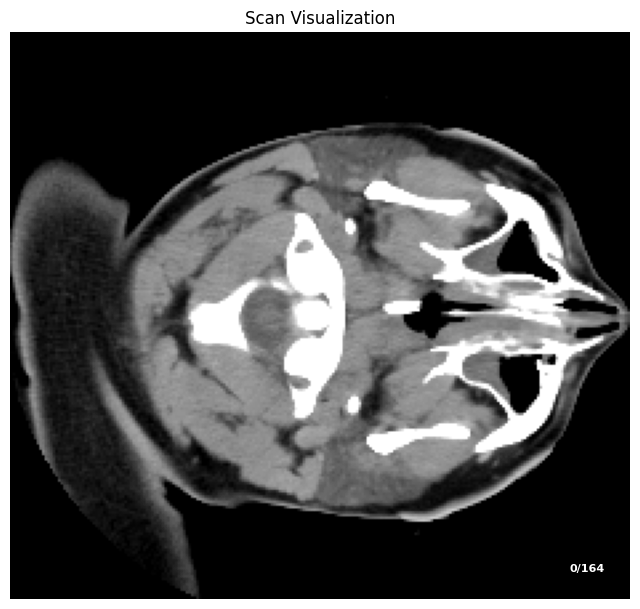

In [7]:
# Visualization
max_slices = 40
anim = visualize(x_img, max_slices=max_slices)

In [8]:
# Generate 3D scan animation with sliding bar
HTML(anim.to_jshtml())